Para conseguir lidar com a analise de sentimentos no rosto humano será necessário utilizar a biblioteca TensorFlow com o ImageDataGenerator

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Para conseguirmos lidar com nosso dataset teremos que definir os caminhos dele

In [2]:
dir_train = "../data/Fer2013Dataset/train"
dir_test = "../data/Fer2013Dataset/test"

# dir_train = "../data/images2/FER2013Train"
# dir_test = "../data/images2/FER2013Test"
# dir_valid = "../data/images2/FER2013Valid"

Agora precisamos criar varaiveis que vão conter transformções que queremos aplicar em nossos datasets.

In [3]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=.1,
    horizontal_flip=True,
    rescale=1./255
)

datagen_valid = ImageDataGenerator(
    rescale=1./255  # Sem augmentations para validação
)

Agora iremos carregar o caminho das imagens para poder preparar elas para treinamento em um modelo

In [4]:
train_generator = datagen_train.flow_from_directory(
    directory=dir_train,
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"  # sem validation_split
)

validation_generator = datagen_valid.flow_from_directory(
    directory=dir_test,  # usando diretório de validação dedicado
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)

# Para avaliação final (opcional):
test_generator = datagen_valid.flow_from_directory(
    directory=dir_test,
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False  # importante para avaliação
)

Found 16664 images belonging to 5 classes.
Found 4157 images belonging to 5 classes.
Found 4157 images belonging to 5 classes.


Verificcando nossa base

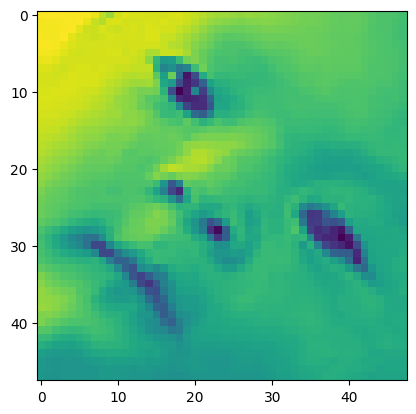

In [5]:
import matplotlib.pyplot as plt

for images, _ in train_generator:
    plt.imshow(images[0])
    plt.show()
    break

# Criando uma CNN para nossa aplicação
Agora que já cuidamos do preprocessamento das nossa imagens, podemos utilizá-las para treinar um modelo CNN. O que iremos utilizar será o mini_XCEPTION

In [6]:
input_shape = (48, 48, 1)
num_classes = 5
l2_regularization = 0.001
patience = 100

In [7]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, SeparableConv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras import layers

In [8]:
regularization = l2(l2_regularization)

Primeiro aplicamos um entrada com o numero de pixels (48,48) e a escala (1), grayscale.

In [9]:
img_input = Input(input_shape)

Temos nossa primeira camada convolucional para nosso modelo

A bias é False, pois aplicamos a normalização na linha seguinte `BatchNormalization`.

In [10]:
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

Depois fazemos um loop de bloco para cada camada posterior. Está em loop, pois serão o mesmo bloco de comando e somente o valor do filtro mudará

In [11]:
filter_list = [16, 32, 64, 128, 256]
for n in filter_list:
    residual = Conv2D(n, (1, 1), strides=(2, 2),
                        padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])



No fim, salvamos nosso modelo criado numa variável

In [12]:
x = Conv2D(num_classes, (3, 3),
            # kernel_regularizer=regularization,
            padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax', name='predictions')(x)

model = Model(img_input, output)

Resumo da arquitetura de rede feita para nosso modelo

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 46, 46, 8) │         72 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 46, 46, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 46, 46, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44, 8) │        576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 44, 44, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 44, 44,    │        200 │ activation_1[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 44, 44,    │        400 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │        128 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 22, 22,    │        656 │ add[0][0]         │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 199,477 (779.21 KB)

 Trainable params: 196,469 (767.46 KB)

 Non-trainable params: 3,008 (11.75 KB)

Compilando o modelo

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Agora iremos trainar nosso modelo com base nos preprocessamentos feitos

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,   
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "melhor_modelo.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [17]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1000,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/1000


c:\Users\gmara\Documents\Sourcetree\PhobiaScan\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3447 - loss: 2.3159
Epoch 1: val_accuracy improved from -inf to 0.40702, saving model to melhor_modelo.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.3448 - loss: 2.3156 - val_accuracy: 0.4070 - val_loss: 1.9498
Epoch 2/1000
520/521 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4402 - loss: 1.8210
Epoch 2: val_accuracy improved from 0.40702 to 0.47967, saving model to melhor_modelo.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.4403 - loss: 1.8207 - val_accuracy: 0.4797 - val_loss: 1.5972
Epoch 3/1000
520/521 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4797 - loss: 1.5516
Epoch 3: val_accuracy improved from 0.47967 to 0.49507, saving model to melhor_modelo.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.4797 - loss: 1.5514 - val_accuracy: 0.4951 - val_loss: 1.4720
Epoch 4/1000
520/521 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5122 - loss: 1.4019
Epoch 4: val_accuracy impro

Plotamos o gráfico de perda durante o treinamento

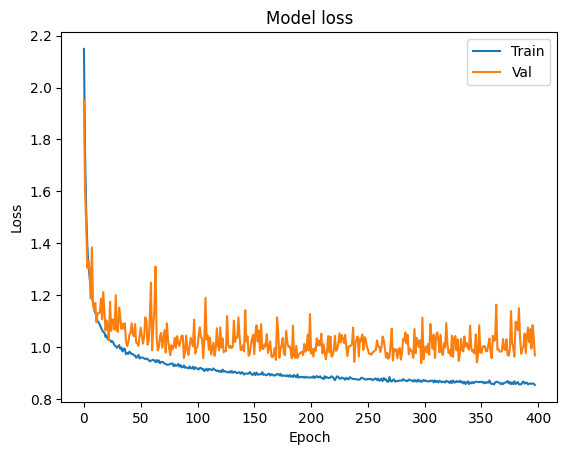

In [18]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Plotamos o gráfico de acurácia durante o treinamento

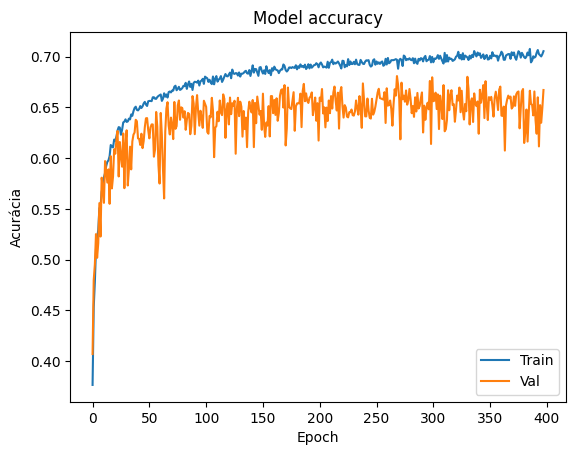

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


Salvamos nosso modelo

In [20]:
model.save("modelo_emocoes.keras")


Dessa forma, podemos agora sempre carregar nosso modelo para testar

In [21]:
from keras.models import load_model
model = load_model("modelo_emocoes.keras")


# Teste

Agora, podemos realizar testes para verificar se nosso modelo está reconhcendo ou não

(456, 292, 3)

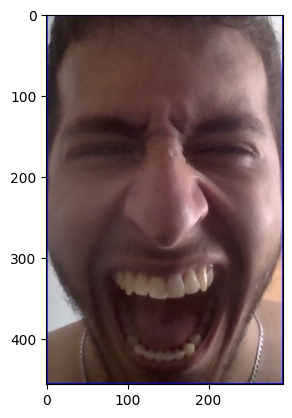

In [22]:
import matplotlib.pyplot as plt
# my_image = plt.imread("../data/FER2013Cleaned/test/fear/fer0000450.png")
my_image = plt.imread("../data/gab/Color/gab.153.jpg")
plt.imshow(my_image)
my_image.shape

Aplicamos transformações de tamanho para ficar no nosso padrão (48,48)

array([[[0.4158088 , 0.42466377, 0.82648417],
        [0.41088937, 0.41132935, 0.59024643],
        [0.17474808, 0.15075316, 0.33688845],
        ...,
        [0.64243334, 0.62769997, 0.79418066],
        [0.76839973, 0.76227674, 0.92327198],
        [0.70464131, 0.70159412, 0.92474937]],

       [[0.4670383 , 0.47388478, 0.75814665],
        [0.35594305, 0.34304467, 0.36354894],
        [0.18519076, 0.14233197, 0.15825854],
        ...,
        [0.62072891, 0.58995526, 0.5979139 ],
        [0.88431022, 0.87116364, 0.885106  ],
        [0.84688958, 0.83789981, 0.9275466 ]],

       [[0.41536863, 0.4066338 , 0.69488312],
        [0.26053332, 0.23174097, 0.24856559],
        [0.16845816, 0.1253612 , 0.12774134],
        ...,
        [0.49188728, 0.447723  , 0.4513558 ],
        [0.73709033, 0.71060064, 0.72276748],
        [0.80890178, 0.7933359 , 0.89147152]],

       ...,

       [[0.2898407 , 0.22944482, 0.47340978],
        [0.40399436, 0.32026465, 0.27100557],
        [0.40054843, 0

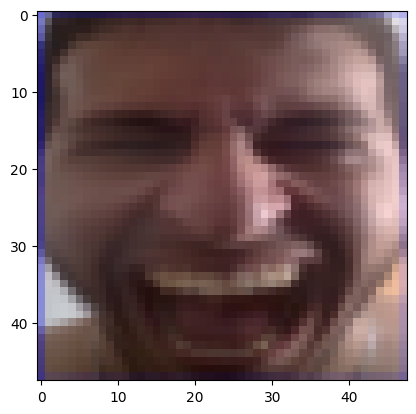

In [23]:
from skimage.transform import resize
my_image_resized = resize(my_image, (48,48,3))

img = plt.imshow(my_image_resized)
my_image_resized


Temos que aplicar uma transformação da imagem pro cinza, visto que treinamos um modelo com a escala cinza

In [24]:
import numpy as np
from skimage.color import rgb2gray

my_image_gray = rgb2gray(my_image_resized) 
my_image_gray = np.expand_dims(my_image_gray, axis=-1)  
my_image_gray = np.expand_dims(my_image_gray, axis=0)

probabilities = model.predict(my_image_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


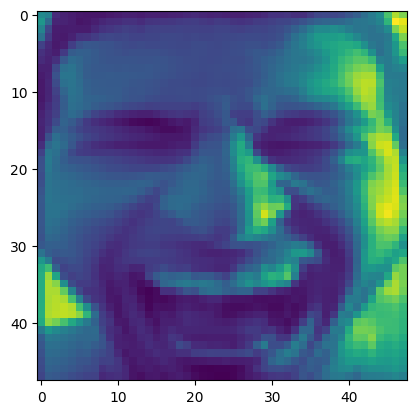

In [25]:
plt.imshow(np.squeeze(my_image_gray))
plt.show()

In [26]:
probabilities

array([[0.5075126 , 0.05492603, 0.3559586 , 0.04744768, 0.03415502]],
      dtype=float32)

Por fim, verificamos as probabilidades de cada emoção

In [27]:
number_to_class = ['angry', 'disgust', 'fear', 'neutral', 'surprise']
index = np.argsort(probabilities[0,:])
print("Most likely class:", number_to_class[index[4]], "-- Probability:", probabilities[0,index[4]])
print("Second most likely class:", number_to_class[index[3]], "-- Probability:", probabilities[0,index[3]])
print("Third most likely class:", number_to_class[index[2]], "-- Probability:", probabilities[0,index[2]])
print("Fourth most likely class:", number_to_class[index[1]], "-- Probability:", probabilities[0,index[1]])
print("Fifth most likely class:", number_to_class[index[0]], "-- Probability:", probabilities[0,index[0]])

Most likely class: angry -- Probability: 0.5075126
Second most likely class: fear -- Probability: 0.3559586
Third most likely class: disgust -- Probability: 0.05492603
Fourth most likely class: neutral -- Probability: 0.04744768
Fifth most likely class: surprise -- Probability: 0.034155022


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Gere predições no conjunto de validação
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Matriz de confusão
print(confusion_matrix(validation_generator.classes, y_pred))

# Relatório por classe
print(classification_report(validation_generator.classes, y_pred,
                           target_names=number_to_class))

130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
[[216   9 177 316 240]
 [ 27   4   9  39  32]
 [269  22 190 329 214]
 [322  15 231 420 245]
 [224  16 124 280 187]]
              precision    recall  f1-score   support

       angry       0.20      0.23      0.21       958
     disgust       0.06      0.04      0.05       111
        fear       0.26      0.19      0.22      1024
     neutral       0.30      0.34      0.32      1233
    surprise       0.20      0.23      0.21       831

    accuracy                           0.24      4157
   macro avg       0.21      0.20      0.20      4157
weighted avg       0.24      0.24      0.24      4157



In [29]:
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'neutral': 3, 'surprise': 4}
